--- Preparando datos para Regresión ---
⚠️ Eliminando 12 columnas de Radios ('rad').
⚠️ Eliminando 5 columnas de Leakage ('sfr').

Variables finales para entrenar: 10
Total de galaxias: 17553

--- Entrenando Neural Net ---


/home/2025/AST0421-1/mvalderrav/astro_env/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Entrenando Random Forest ---

   RESULTADOS (Sin Radios 'rad' y Sin Leakage)   
Modelo          | Tiempo(s)  | R2 Score  
---------------------------------------------
Neural Net      | 12.06      | 0.9010    
Random Forest   | 1.11       | 0.9316    
---------------------------------------------


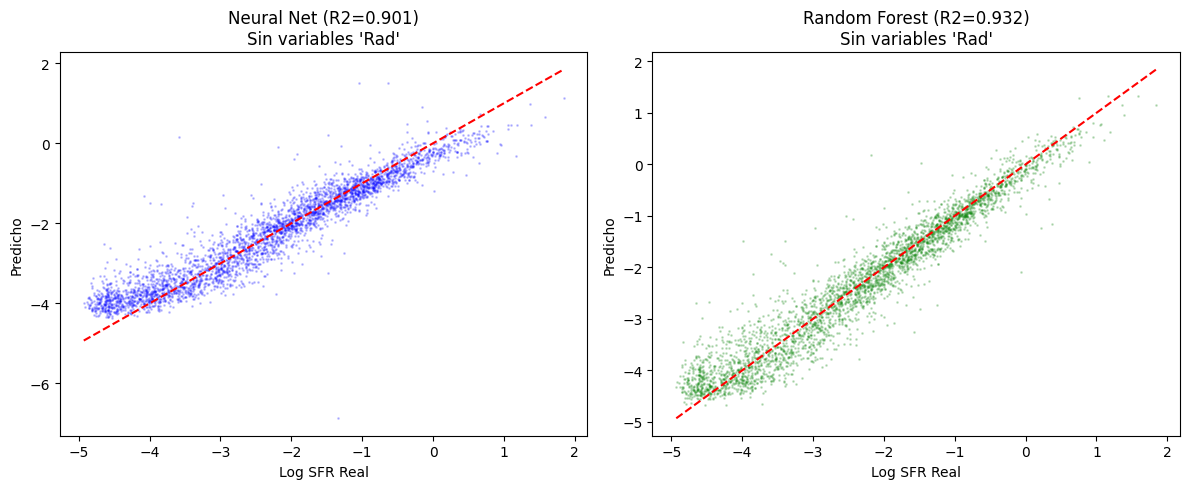

In [12]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


df_clean = pd.read_pickle("tng099_clean.pkl")

# ============================================================
# 1. PREPARACIÓN DE DATOS (LIMPIEZA DOBLE: LEAKAGE + RAD)
# ============================================================
print("--- Preparando datos para Regresión ---")

# A. Filtramos SOLO galaxias que forman estrellas (SFR > 0)
df_reg = df_clean[df_clean["SubhaloSFR"] > 0].copy()

if len(df_reg) > 150000:
    df_reg = df_reg.sample(n=150000, random_state=42)

all_cols = df_reg.columns

rad_cols = [c for c in all_cols if 'rad' in c.lower()]

leakage_cols = [c for c in all_cols if 'sfr' in c.lower() and c != 'SubhaloSFR']


cols_to_drop = list(set(rad_cols + leakage_cols + ['SubhaloSFR', 'JellyfishFlag']))

print(f" Eliminando {len(rad_cols)} columnas de Radios ('rad').")
print(f" Eliminando {len(leakage_cols)} columnas de Leakage ('sfr').")


X = df_reg.drop(columns=cols_to_drop)

# Target Logarítmico
y = np.log10(df_reg['SubhaloSFR'])

print(f"\nVariables finales para entrenar: {X.shape[1]}")
print(f"Total de galaxias: {len(X)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_sc = scaler_X.fit_transform(X_train)
X_test_sc = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

# ============================================================
# 2. RED NEURONAL (Optimizado para Regresión)
# ============================================================
def build_regressor():
    model = Sequential()
    # Capa 1
    model.add(Dense(64, input_shape=(X_train_sc.shape[1],), activation='relu'))
    model.add(BatchNormalization()) 
    model.add(Dropout(0.2)) # Un poco más de dropout para evitar memorización
    
    # Capa 2
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    
    # Salida Lineal
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model_nn = build_regressor()
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

print("\n--- Entrenando Neural Net ---")
start_nn = time.time()
history = model_nn.fit(
    X_train_sc, y_train_sc, 
    epochs=60,
    batch_size=128, 
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)
time_nn = time.time() - start_nn


pred_scaled_nn = model_nn.predict(X_test_sc)
y_pred_nn = scaler_y.inverse_transform(pred_scaled_nn).flatten()

# ============================================================
# 3. RANDOM FOREST
# ============================================================
print("\n--- Entrenando Random Forest ---")
rf = RandomForestRegressor(n_estimators=300, max_depth=15, n_jobs=-1, random_state=42)

start_rf = time.time()
rf.fit(X_train, y_train) 
time_rf = time.time() - start_rf

y_pred_rf = rf.predict(X_test)

# ============================================================
# 4. COMPARACIÓN FINAL
# ============================================================
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n" + "="*45)
print("   RESULTADOS (Sin Radios 'rad' y Sin Leakage)   ")
print("="*45)
print(f"{'Modelo':<15} | {'Tiempo(s)':<10} | {'R2 Score':<10}")
print("-" * 45)
print(f"{'Neural Net':<15} | {time_nn:<10.2f} | {r2_nn:<10.4f}")
print(f"{'Random Forest':<15} | {time_rf:<10.2f} | {r2_rf:<10.4f}")
print("-" * 45)

# Gráfico Comparativo
plt.figure(figsize=(12, 5))

# Plot Neural Net
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_nn, s=1, alpha=0.2, c='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Neural Net (R2={r2_nn:.3f})\nSin variables 'Rad'")
plt.xlabel("Log SFR Real")
plt.ylabel("Predicho")

# Plot Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, s=1, alpha=0.2, c='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Random Forest (R2={r2_rf:.3f})\nSin variables 'Rad'")
plt.xlabel("Log SFR Real")
plt.ylabel("Predicho")

plt.tight_layout()
plt.show()

Buscamos los mejores parametros ahora, apra ver si RN supero a RF

In [11]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ============================================================
# 1. DEFINIMOS LAS 3 ESTRATEGIAS (CONFIGURACIONES)
# ============================================================
configs = [
    # ESTRATEGIA 1: "La Minimalista" (Pocos parámetros, evita overfitting)
    {"name": "Light", "layers": [32, 16], "dropout": 0.1, "lr": 0.001},
    
    # ESTRATEGIA 2: "La Estándar" (Equilibrio clásico)
    {"name": "Balanced", "layers": [64, 32], "dropout": 0.2, "lr": 0.001},
    
    # ESTRATEGIA 3: "La Profunda" (Intenta capturar patrones complejos)
    {"name": "Deep & Wide", "layers": [128, 64, 32], "dropout": 0.3, "lr": 0.0005}
]

best_r2 = -999
best_model_name = ""
results = []

print(f"--- Iniciando Torneo de Redes Neuronales ---")
print(f"Random Forest a vencer (Referencia): R2 ~ 0.9408\n")

# ============================================================
# 2. BUCLE DE ENTRENAMIENTO MANUAL
# ============================================================
for conf in configs:
    print(f"Entrenando configuración: {conf['name']} ...")
    
    # Construcción dinámica del modelo
    model = Sequential()
    
    # Primera capa (necesita input_shape)
    model.add(Dense(conf['layers'][0], input_shape=(X_train_sc.shape[1],), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(conf['dropout']))
    
    # Capas intermedias (si hay más en la lista)
    for units in conf['layers'][1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(conf['dropout']))
        
    # Capa de salida
    model.add(Dense(1, activation='linear'))
    
    # Compilar
    optimizer = Adam(learning_rate=conf['lr'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    
    # Entrenar
    start_t = time.time()
    hist = model.fit(
        X_train_sc, y_train_sc,
        epochs=40,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )
    duration = time.time() - start_t
    
    # Evaluar
    pred_scaled = model.predict(X_test_sc)
    y_pred_real = scaler_y.inverse_transform(pred_scaled).flatten()
    current_r2 = r2_score(y_test, y_pred_real)
    
    print(f"   -> R2: {current_r2:.4f} | Tiempo: {duration:.2f}s")
    
    # Guardar resultados
    results.append({"Model": conf['name'], "R2": current_r2, "Time": duration})
    
    if current_r2 > best_r2:
        best_r2 = current_r2
        best_model_name = conf['name']

# ============================================================
# 3. RESULTADOS FINALES
# ============================================================
print("\n" + "="*40)
print("   TABLA DE POSICIONES FINAL   ")
print("="*40)
print(f"{'Configuración':<15} | {'R2 Score':<10} | {'Diferencia con RF'}")
print("-" * 55)

rf_score_ref = 0.9408  

for res in results:
    diff = res['R2'] - rf_score_ref
    simbolo = "+" if diff > 0 else ""
    print(f"{res['Model']:<15} | {res['R2']:<10.4f} | {simbolo}{diff:.4f}")

print("-" * 55)

if best_r2 > rf_score_ref:
    print(f"🎉 ¡ÉXITO! La configuración '{best_model_name}' superó al Random Forest.")
else:
    print(f"📉 CONCLUSIÓN: Ninguna arquitectura logró superar el 0.9408 del Random Forest.")
    print("   Esto confirma que los árboles de decisión son el modelo dominante para estos datos.")

--- Iniciando Torneo de Redes Neuronales ---
Random Forest a vencer (Referencia): R2 ~ 0.9408

Entrenando configuración: Light ...


/home/2025/AST0421-1/mvalderrav/astro_env/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   -> R2: 0.8687 | Tiempo: 12.69s
Entrenando configuración: Balanced ...


/home/2025/AST0421-1/mvalderrav/astro_env/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   -> R2: 0.8872 | Tiempo: 16.90s
Entrenando configuración: Deep & Wide ...


/home/2025/AST0421-1/mvalderrav/astro_env/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   -> R2: 0.8897 | Tiempo: 22.84s

   TABLA DE POSICIONES FINAL   
Configuración   | R2 Score   | Diferencia con RF
-------------------------------------------------------
Light           | 0.8687     | -0.0721
Balanced        | 0.8872     | -0.0536
Deep & Wide     | 0.8897     | -0.0511
-------------------------------------------------------
📉 CONCLUSIÓN: Ninguna arquitectura logró superar el 0.9408 del Random Forest.
   Esto confirma que los árboles de decisión son el modelo dominante para estos datos.
